## 서울시 따릉이 자전거 이용 예측 AI모델
각 날짜의 1시간 전의 기상상황을 활용 하여 따릉이 대여수를 예측해 보세요.
### 1. train.csv / test.csv
- id: 고유 id
- hour: 시간
- temperature: 기온
- precipitation: 비가 오지 않았으면 0, 비가 오면 1
- windspeed: 풍속(평균)
- humidity: 습도
- visibility: 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
- ozone: 오존
- pm10: 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
- pm2.5: 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
- count: 시간에 따른 따릉이 대여 수


### 2.  submission.csv (제출 파일 형식)

### 3. 데이터 상세 설명
- 서울시 마포구의 날짜별, 시간별 기상상황과 따릉이 대여 수 데이터

#### `1.` 라이브러리 임포트

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


#### `2.` 데이터 로드

In [2]:
train_data = pd.read_csv('./따릉이/train.csv')
test_data = pd.read_csv('./따릉이/test.csv')
submission_data = pd.read_csv('./따릉이/submission.csv')

#### `3-1.` 데이터 정보 확인 (train_data)

In [3]:
display(train_data)
print(train_data.info())

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0
...,...,...,...,...,...,...,...,...,...,...,...
1454,2174,4,16.8,0.0,1.6,53.0,2000.0,0.031,37.0,27.0,21.0
1455,2175,3,10.8,0.0,3.8,45.0,2000.0,0.039,34.0,19.0,20.0
1456,2176,5,18.3,0.0,1.9,54.0,2000.0,0.009,30.0,21.0,22.0
1457,2178,21,20.7,0.0,3.7,37.0,1395.0,0.082,71.0,36.0,216.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB
None


#### `3-2.` 데이터 정보 확인 (test_data)

In [4]:
display(test_data)
print(test_data.info())

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0
2,2,13,19.0,1.0,2.1,95.0,193.0,0.020,36.0,28.0
3,4,6,22.5,0.0,2.5,60.0,1185.0,0.027,52.0,38.0
4,5,22,14.6,1.0,3.4,93.0,218.0,0.041,18.0,15.0
...,...,...,...,...,...,...,...,...,...,...
710,2148,1,24.6,0.0,2.4,60.0,1745.0,NaN,NaN,NaN
711,2149,1,18.1,0.0,1.0,55.0,2000.0,NaN,NaN,NaN
712,2165,9,23.3,0.0,2.3,66.0,1789.0,0.020,17.0,15.0
713,2166,16,27.0,0.0,1.6,46.0,1956.0,0.032,40.0,26.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      715 non-null    int64  
 1   hour                    715 non-null    int64  
 2   hour_bef_temperature    714 non-null    float64
 3   hour_bef_precipitation  714 non-null    float64
 4   hour_bef_windspeed      714 non-null    float64
 5   hour_bef_humidity       714 non-null    float64
 6   hour_bef_visibility     714 non-null    float64
 7   hour_bef_ozone          680 non-null    float64
 8   hour_bef_pm10           678 non-null    float64
 9   hour_bef_pm2.5          679 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 56.0 KB
None


#### `3-3.` 데이터 정보 확인 (submission_data)

In [5]:
display(submission_data)
print(submission_data.info())

,id,count
0,0,NaN
1,1,NaN
2,2,NaN
3,4,NaN
4,5,NaN
...,...,...
710,2148,NaN
711,2149,NaN
712,2165,NaN
713,2166,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      715 non-null    int64  
 1   count   0 non-null      float64
dtypes: float64(1), int64(1)
memory usage: 11.3 KB
None


#### `4.` 데이터 전처리: 컬럼명 변경

In [6]:
# 데이터 설명과 상이하여 보기쉽게 컬럼명을 변경하겠습니다.
train_data.rename(columns={'hour_bef_temperature':'temperature', 'hour_bef_precipitation':'precipitation',
                           'hour_bef_windspeed':'windspeed', 'hour_bef_humidity':'humidity', 
                           'hour_bef_visibility':'visibility', 'hour_bef_ozone':'ozone', 'hour_bef_pm10':'pm10',
                           'hour_bef_pm2.5':'pm2.5'}, inplace=True)

test_data.rename(columns={'hour_bef_temperature':'temperature', 'hour_bef_precipitation':'precipitation',
                          'hour_bef_windspeed':'windspeed', 'hour_bef_humidity':'humidity', 
                          'hour_bef_visibility':'visibility', 'hour_bef_ozone':'ozone', 'hour_bef_pm10':'pm10',
                          'hour_bef_pm2.5':'pm2.5'}, inplace=True)

# 컬럼명 변경 후 데이터를 확인합니다.
print(train_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1459 non-null   int64  
 1   hour           1459 non-null   int64  
 2   temperature    1457 non-null   float64
 3   precipitation  1457 non-null   float64
 4   windspeed      1450 non-null   float64
 5   humidity       1457 non-null   float64
 6   visibility     1457 non-null   float64
 7   ozone          1383 non-null   float64
 8   pm10           1369 non-null   float64
 9   pm2.5          1342 non-null   float64
 10  count          1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             715 non-null    int64  
 1   hour           715 non

#### `5.` 데이터 전처리: 상관관계 확인

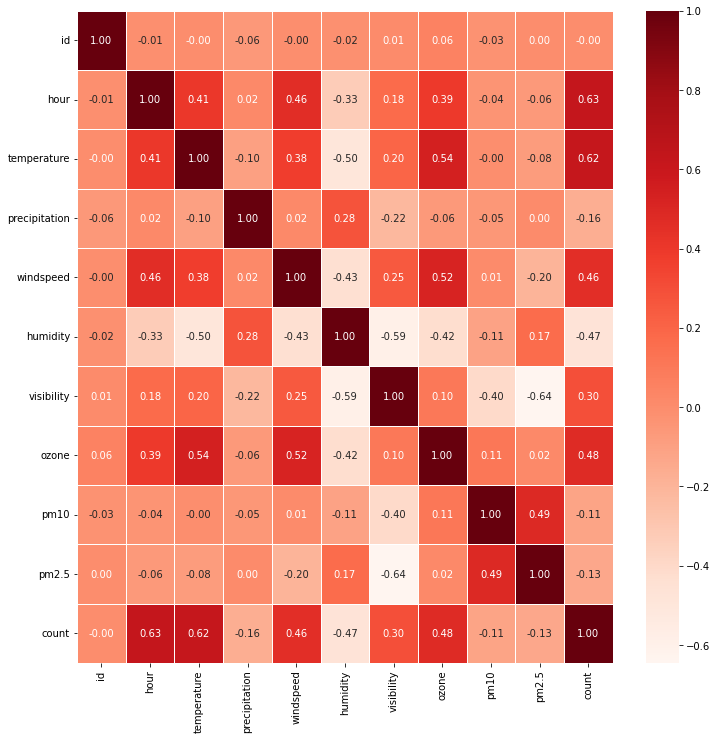

In [7]:
# 히트맵으로 각 데이터별 상관관계를 시각화합니다.
plt.figure(figsize=(12,12))              # plt.figure(figsize=(15,15)): 15x15의 크기로 그림을 그려달라는 것입니다.
sns.heatmap(data=train_data.corr(),      # data=: 시각화에 사용할 자료를 선택합니다.
            annot=True,                  # annot=: 셀 안에 숫자 표시 여부를 지정합니다.
            fmt='.2f',                   # fmt=: annot=True인 경우 숫자의 표시 형식을 지정합니다.
            linewidths=.5,               # linewidths=: 각 셀을 나눌 선의 두께를 지정합니다. 
            cmap='Reds')                 # cmap=: 표의 섹상을 지정합니다.

plt.show()

#### `6.` 데이터 전처리: 드랍

In [8]:
# target과 feature의 영향이 적은 id 컬럼은 드랍하겠습니다.
train_data.drop(columns=['id'], inplace=True)
test_data.drop(columns=['id'], inplace=True)

#### `7.` 데이터 전처리: 결측값 처리

In [11]:
# 결측값을 확인합니다.
print('-----train_data 결측값-----')
print(train_data.isna().sum())
print('-----test_data 결측값-----')
print(test_data.isna().sum())

-----train_data 결측값-----
hour               0
temperature        2
precipitation      2
windspeed          9
humidity           2
visibility         2
ozone             76
pm10              90
pm2.5            117
count              0
dtype: int64
-----test_data 결측값-----
hour              0
temperature       1
precipitation     1
windspeed         1
humidity          1
visibility        1
ozone            35
pm10             37
pm2.5            36
dtype: int64


#### `7-1.` 데이터 전처리: 결측값 처리 (temperature)

In [ ]:
# 결측값 개수가 적고 target의 상관관계가 높으므로  target을 기준으로 피쳐의 평균을 구해 결측값을 치환하겠습니다.
# temperature 컬럼의 결측값이 있는 행의 인덱스 번호를 추출합니다.
nan_idx = train_data[train_data['temperature'].isna() == 1].index


In [40]:
train_data.groupby('temperature').mean()

b = train_data[train_data['count'] == 39].index
train_data.iloc[b]

,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
5,2,13.6,0.0,1.7,80.0,1073.0,0.027,34.0,15.0,39.0
8,9,13.8,0.0,1.9,64.0,1344.0,0.039,93.0,19.0,39.0
84,1,9.4,0.0,2.5,65.0,1907.0,NaN,NaN,NaN,39.0
374,7,12.8,0.0,1.4,84.0,235.0,0.031,114.0,67.0,39.0
671,2,17.4,0.0,1.3,44.0,1319.0,0.023,68.0,41.0,39.0
708,1,11.6,0.0,0.6,52.0,1853.0,NaN,NaN,NaN,39.0
713,19,16.7,1.0,0.7,88.0,577.0,0.037,82.0,37.0,39.0
811,1,19.3,0.0,1.9,78.0,715.0,NaN,NaN,NaN,39.0
934,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0


In [35]:
a = train_data[train_data['temperature'].isna() == 1].index

In [36]:
train_data.iloc[a]

,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
934,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1035,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
